##### Imports

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np
from econml.dml import DML
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from scipy.special import expit
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression
from genriesz import SquaredGenerator, grr_ate, PolynomialBasis
from pathlib import Path

from gg570_d200.external_code.forestriesz import ForestRieszATE

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [7]:
root = Path.cwd().parent
data_path = root / "data/apsp_o24s25_eul_pwta22.dta"

##### Initial exploration and wrangling

In [8]:
df = pd.read_stata(data_path, convert_categoricals=False)

In [9]:
df
# Training in past 3 months on current underemployment hours
# https://datacatalogue.ukdataservice.ac.uk/studies/study/9500#details
# https://doc.ukdataservice.ac.uk/doc/9500/mrdoc/pdf/9500_lfs_user_guide_vol3_variabledetails2022js.pdf
# https://doc.ukdataservice.ac.uk/doc/9500/mrdoc/pdf/9500_lfs_user_guide_vol6_aps_user_guide_2024.pdf
# https://doc.ukdataservice.ac.uk/doc/9500/mrdoc/pdf/9500_lfs_user_guide_vol2_questionnaire_2022jscombined.pdf
# https://doc.ukdataservice.ac.uk/doc/9500/mrdoc/pdf/9500_lfs_user_guide_vol6_aps_user_guide_2024.pdf

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,12,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
1,12,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
2,4,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
3,13,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
4,8,30.0,-9.0,0.0,0.0,2,3,5,-9,-9,...,-9,-9,13,-9,-9,-9,-9,-9,-9,-9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176025,9,-9.0,-9.0,-9.0,-9.0,1,2,3,4,5,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
176026,2,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
176027,13,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9
176028,13,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,-9,...,-9,-9,-9,-9,-9,-9,-9,-9,-9,-9


In [10]:
df = df.drop(columns='idref')

In [11]:
df.rename(columns={'UNDHRS': 'Underemployment hours',
                   'ED13WK': 'Training (last 3 months)'}, inplace=True)

In [12]:
df['Underemployment hours'].value_counts().sort_index()

Underemployment hours
-9.0     169490
 1.0         37
 1.5          3
 2.0        175
 2.5         33
          ...  
 56.0         1
 60.0         1
 72.0         1
 97.0         7
 99.0       274
Name: count, Length: 88, dtype: int64

In [13]:
df['Training (last 3 months)'].value_counts().sort_index()

Training (last 3 months)
-9    99794
-8      194
 1    19670
 2    56372
Name: count, dtype: int64

In [14]:
df.dtypes.value_counts()

int8       493
int16       19
float64     16
str         11
int32        8
Name: count, dtype: int64

In [15]:
cols_to_adjust = list(df.select_dtypes(exclude=['number']).columns)

In [16]:
df.loc[:, cols_to_adjust].head()

,BANDG,BANDG2,BANDN,BANDN2,CTRY9D,FDSNGDEG,GOR9DCENSUS2021,PARK,REFDTE,SNGDEGN,SNGHD
0,-9,-9,-9,-9,E92000001,-9,E12000009,E65000001,06102024,-9,-9
1,-9,-9,-9,-9,E92000001,-9,E12000009,E65000001,06102024,-9,-9
2,-9,-9,-9,-9,E92000001,-9,E12000009,E65000001,06102024,-9,-9
3,-9,-9,-9,-9,E92000001,-9,E12000009,E65000001,06102024,-9,-9
4,-9,-9,-9,-9,E92000001,-9,E12000009,E65000001,06102024,-9,-9


In [17]:
cols_to_float = ['BANDG', 'BANDG2', 'BANDN', 'BANDN2']
df[cols_to_float] = df[cols_to_float].astype('float64')

In [18]:
cols_to_drop = [col for col in cols_to_adjust if col not in cols_to_float]
df = df.drop(columns=cols_to_drop, errors='ignore')

In [19]:
df = df.drop(columns=df.columns[((df == -8) | (df == -9)).sum() / len(df) > 0.5].difference(['Underemployment hours', 'Training (last 3 months)']))
# Drop cols with more than 50% missing data

In [20]:
df = df[~((df == -8) | (df == -9)).any(axis=1)]
non_age_cols = df.columns.difference(['age', 'aage'])
df = df[~(df[non_age_cols] == 99).any(axis=1)]

---

In [21]:
set(df.nunique().sort_values(ascending=False))

In [22]:
df.nunique()[df.nunique().between(31, 1173)].sort_values(ascending=False)
#

NPWT22                   1173
PWTA22                    862
PIWTA22                   830
Underemployment hours      65
AGE                        48
HIQUAL22                   39
HITQUA15                   31
REFWKD                     31
dtype: int64

In [23]:
df = df.drop(columns=['NPWT22', 'PWTA22', 'PIWTA22'])

In [24]:
df.nunique()[df.nunique().between(2, 15)].sort_values(ascending=False)
#

LKWFWM            15
CRYOX7_EUL_Sub    14
NSECM20           14
REFWKM            12
edageband         12
                  ..
QUAL21_11          2
QUAL21_13          2
QUAL21_14          2
QUAL21_15          2
WRKING             2
Length: 96, dtype: int64

In [25]:
cols_to_bin = list(df.columns[df.nunique().between(2, 15)].difference(['Training (last 3 months)']))
for col in cols_to_bin:
    df = pd.concat([df, pd.get_dummies(pd.cut(df[col], bins=min(5, df[col].nunique())), prefix=f'{col}_bin', dtype=int)], axis=1)
    df = df.drop(columns=col)

In [26]:
df['Training (last 3 months)'] = df['Training (last 3 months)'].replace(2, 0)

In [27]:
vars_of_interest = ['Underemployment hours', 'Training (last 3 months)']
other_vars = sorted([col for col in df.columns if col not in vars_of_interest])
df = df[vars_of_interest + other_vars]

In [28]:
df.head()

,Underemployment hours,Training (last 3 months),"AAGE_bin_(1.99, 4.0]","AAGE_bin_(10.0, 12.0]","AAGE_bin_(4.0, 6.0]","AAGE_bin_(6.0, 8.0]","AAGE_bin_(8.0, 10.0]",AGE,"ANXIOUS_bin_(-0.01, 2.0]","ANXIOUS_bin_(2.0, 4.0]",...,"WORTH_bin_(4.0, 6.0]","WORTH_bin_(6.0, 8.0]","WORTH_bin_(8.0, 10.0]","WRKING_bin_(0.999, 1.5]","WRKING_bin_(1.5, 2.0]","edageband_bin_(10.916, 27.8]","edageband_bin_(27.8, 44.6]","edageband_bin_(44.6, 61.4]","edageband_bin_(61.4, 78.2]","edageband_bin_(78.2, 95.0]"
20,10.0,1,0,0,0,1,0,44,0,0,...,0,1,0,1,0,1,0,0,0,0
137,5.0,0,0,0,0,1,0,39,1,0,...,0,1,0,1,0,1,0,0,0,0
156,3.0,0,0,0,0,0,1,53,1,0,...,0,0,1,1,0,1,0,0,0,0
231,5.0,0,0,0,1,0,0,29,0,0,...,0,1,0,1,0,1,0,0,0,0
269,8.0,0,0,0,1,0,0,28,1,0,...,0,1,0,1,0,1,0,0,0,0


---

##### Overlap

In [29]:
non_covariate_cols = ['Underemployment hours', 'Training (last 3 months)']
covariate_cols = [col for col in df.columns if col not in non_covariate_cols]

In [30]:
def propensity_scores(df, covariate_cols, treatment_col):
    log_model = LogisticRegression(solver='liblinear')
    log_model.fit(df[covariate_cols], df[treatment_col])
    
    prop_scores = log_model.predict_proba(df[covariate_cols])[:, 1]
    return prop_scores

In [46]:
scaler = StandardScaler()

df_scaled = scaler.fit_transform(df[covariate_cols])
df_scaled = pd.DataFrame(df_scaled, columns=covariate_cols, index=df.index)
df_scaled['Training (last 3 months)'] = df['Training (last 3 months)']
df_scaled['Underemployment hours'] = df['Underemployment hours']

df_scaled['prop_scores'] = propensity_scores(df_scaled, covariate_cols, 'Training (last 3 months)')

In [47]:
def plot_propensity_scores(df, treatment_col, prop_score_col):

    plt.figure(figsize=(10, 6))

    treated = df[df[treatment_col] == 1][prop_score_col]
    control = df[df[treatment_col] == 0][prop_score_col]

    plt.hist(treated, bins=30, alpha=0.5, label='Treated (1)', density=True, color='blue')
    plt.hist(control, bins=30, alpha=0.5, label='Control (0)', density=True, color='orange')

    plt.xlabel('Propensity Score')
    plt.ylabel('Density')
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.legend()
    plt.title('Propensity Score Densities (by Treatment Status)')
    plt.show()

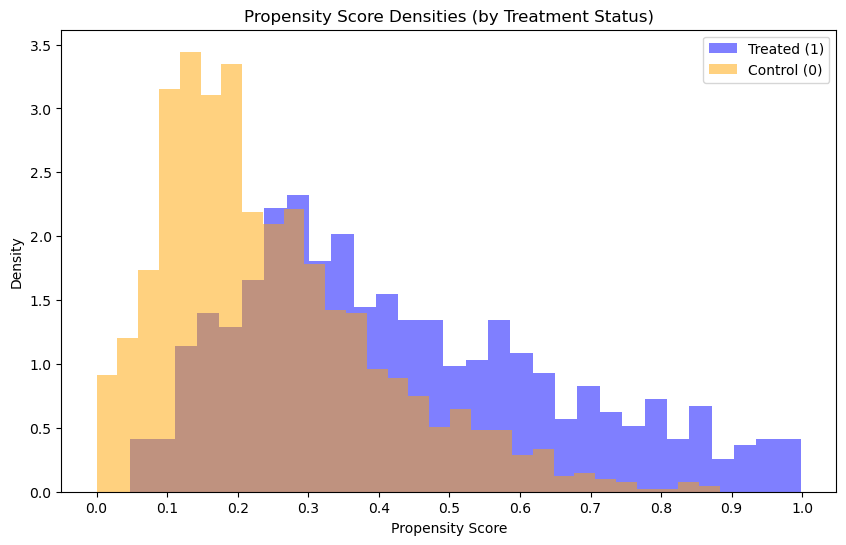

In [48]:
plot_propensity_scores(df_scaled, 'Training (last 3 months)', 'prop_scores')

In [49]:
def overlap_measures(df, treatment_col, prop_scores_col):
    extreme_scores_perc = round(100 * (len(df[(df[prop_scores_col] < 0.05) | (df[prop_scores_col] > 0.95)])/len(df)), 2)

    ipw = np.where(df[treatment_col] == 1, 1/df[prop_scores_col], 1/(1 - df[prop_scores_col]))
    ess = (np.sum(ipw)**2) / np.sum(ipw**2)
    ess_perc = round(100 * (ess/len(df)), 2)

    return extreme_scores_perc, ess_perc

In [61]:
true_extreme_scores_perc, true_ess_perc = overlap_measures(df_scaled, 'Training (last 3 months)', 'prop_scores')
true_extreme_scores_perc, true_ess_perc

KeyError: 'prop_scores'

---

##### Synthetic measures

In [51]:
np.random.seed(21)

In [37]:
def synthetic_data(scaled_covars, overlap_intensity, synthetic_ate, return_heterogeneity=False):
    scaled_covars = np.asarray(scaled_covars)
    n, p = scaled_covars.shape
    
    covariate_coefs = np.random.normal(0, 1, (p, 3)) # Col 0 for selection, col 1 for outcome, col 2 for heterogeneity
    
    matrix_mult = scaled_covars @ covariate_coefs # Again, col 0 for selection, col 1 for outcome, col 2 for heterogeneity

    prob_assign = expit(overlap_intensity * matrix_mult[:, 0])
    synthetic_treat = np.random.binomial(1, prob_assign) # for each observation i, assign treat with prob = prob_assign_i
    
    heterogeneous_component = 0.01 * matrix_mult[:, 2]**2 # add some nonlinearity to the heterogeneity
    heterogeneous_component -= np.mean(heterogeneous_component) # centre the heterogeneous component to have mean zero, so that the ATE is not affected by the heterogeneity
    
    synthetic_y = ((synthetic_ate + heterogeneous_component) * synthetic_treat) + (matrix_mult[:, 1]) + np.random.normal(0, 1, n) # normal errors
    
    if return_heterogeneity:
        return synthetic_y, synthetic_treat, heterogeneous_component
    else:
        return synthetic_y, synthetic_treat

In [38]:
def riesz_ate(df, treat_and_covariate_cols, outcome_col):
    riesz_estimate = grr_ate(
        X=df[treat_and_covariate_cols],
        Y=df[outcome_col],
        basis=PolynomialBasis(degree=1),
        generator=SquaredGenerator(C=0.0).as_generator(),
        treatment_index=0,
        cross_fit=True,
        folds=5,
        random_state=21,
        riesz_penalty='l2',
        riesz_lam=1e-3,
    )

    return riesz_estimate

---

In [98]:
methods = ['dr', 'plugin']
# results=[]

def call_forestriesz(df, covariate_cols, treat_col, outcome_col):
    covariates = df[covariate_cols].values
    treat = df[treat_col].values
    outcome = df[outcome_col].values
    
    """
    y_scaler = StandardScaler(with_mean=True).fit(outcome.reshape(-1, 1))
    outcome = y_scaler.transform(outcome.reshape(-1, 1))
    """
    
    est = ForestRieszATE(criterion='mse', n_estimators=100, min_samples_leaf=2,
                         min_var_fraction_leaf=0.001, min_var_leaf_on_val=True,
                         min_impurity_decrease = 0.01, max_samples=.8, max_depth=None,
                         warm_start=False, inference=False, subforest_size=1,
                         honest=True, verbose=0, n_jobs=-1, random_state=21)
    
    est.fit(covariates, treat, outcome)

    """
    params = tuple(x * y_scaler.scale_[0] for method in methods
                   for x in est.predict_ate(df[[treat_col] + covariate_cols].values, outcome, method=method)) + (10, )
                        
    results.append(params)

    res = tuple(np.array(x) for x in zip(*results))
    truth = res[-1:]
    res_dict = {}
    for it, method in enumerate(methods):
        point, lb, ub = res[it * 3: (it + 1)*3]
        res_dict[method] = {'point': point, 'lb': lb, 'ub': ub,
                            'MAE': np.mean(np.abs(point - truth)),
                            'std. err.': np.std(np.abs(point - truth)) / np.sqrt(len(results)),
                            }
        print("{} : MAE = {:.3f} +/- {:.3f}".format(method, res_dict[method]['MAE'], res_dict[method]['std. err.']))
    """

    results = {}
    
    for method in methods:
        ate = est.predict_ate(df[[treat_col] + covariate_cols].values, outcome, method=method)
        # ate = tuple((np.asarray(ate, dtype=float) * y_scaler.scale_[0]).tolist())
        results[method] = {'est' : ate[0],
                           'low' : ate[1],
                           'high' : ate[2]}

    return results

In [ ]:
# call_forestriesz(df_scaled, covariate_cols, 'Training (last 3 months)', 'Underemployment hours')

{'dr': {'est': -0.23271223304067576,
  'low': -0.7963380345985351,
  'high': 0.33091356851718357},
 'plugin': {'est': -0.029823248273641842,
  'low': -0.29428390981737634,
  'high': 0.23463741327009263}}

In [ ]:
"""
def call_forestriesz_noscale(df, covariate_cols, treat_col, outcome_col):
    covariates = df[covariate_cols].values
    treat = df[treat_col].values
    outcome = df[outcome_col].values.reshape(-1, 1)

    est = ForestRieszATE(criterion='mse', n_estimators=100, min_samples_leaf=2,
                         min_var_fraction_leaf=0.001, min_var_leaf_on_val=True,
                         min_impurity_decrease=0.01, max_samples=.8, max_depth=None,
                         warm_start=False, inference=False, subforest_size=1,
                         honest=True, verbose=0, n_jobs=-1, random_state=123)

    est.fit(covariates, treat, outcome)

    for method in methods:
        ate = est.predict_ate(df[[treat_col] + covariate_cols].values, outcome, method=method)
        print(f"NO-SCALE ATE estimate using {method} method: {ate}")

call_forestriesz_noscale(df_scaled, covariate_cols, 'Training (last 3 months)', 'Underemployment hours')
"""

NO-SCALE ATE estimate using dr method: (-0.2688837483952019, -0.8340877002844266, 0.29632020349402277)
NO-SCALE ATE estimate using plugin method: (-0.029823248273641842, -0.29428390981737634, 0.23463741327009263)


---

In [ ]:
def synthetic_loop(df_scaled, covariate_cols, iterations, synthetic_ate):
    iterations_dict = {'overlap_intensity': np.zeros(iterations),
                       'extreme_scores': np.zeros(iterations),
                       'ess': np.zeros(iterations),
                       'dr_estimates': np.zeros(iterations),
                       'dr_in_ci': np.zeros(iterations),
                       'plugin_estimates': np.zeros(iterations),
                       'plugin_in_ci': np.zeros(iterations)}

    overlap_arr = iterations_dict['overlap_intensity']
    extreme_arr = iterations_dict['extreme_scores']
    ess_arr = iterations_dict['ess']
    dr_est = iterations_dict['dr_estimates']
    dr_ci = iterations_dict['dr_in_ci']
    plugin_est = iterations_dict['plugin_estimates']
    plugin_ci = iterations_dict['plugin_in_ci']

    df_scaled_covars = df_scaled[covariate_cols]
    df_scaled_synthetic = df_scaled_covars.copy()
    synthetic_y = 'synthetic_y'
    synthetic_treat = 'synthetic_treat'
    prop_scores = 'prop_scores'

    print_cases = max(1, iterations // 10)

    for i in range(iterations):
        if i % print_cases == 0:
            print(i)

        overlap_intensity = np.random.uniform(0, 1) # Randomly select an overlap intensity for the synthetic data.
        
        df_scaled_synthetic[synthetic_y], df_scaled_synthetic[synthetic_treat] = synthetic_data(df_scaled_covars, overlap_intensity, synthetic_ate)
        df_scaled_synthetic[prop_scores] = propensity_scores(df_scaled_synthetic, covariate_cols, synthetic_treat)
        #plot_propensity_scores(df_scaled_synthetic, synthetic_treat, prop_scores)
        extreme_scores, ess = overlap_measures(df_scaled_synthetic, synthetic_treat, prop_scores)

        riesz_estimate = call_forestriesz(df_scaled_synthetic, covariate_cols, synthetic_treat, synthetic_y)
        # riesz_estimate = riesz_ate(df_scaled_synthetic, treat_and_covariate_cols, synthetic_y)

        overlap_arr[i] = overlap_intensity
        extreme_arr[i] = extreme_scores
        ess_arr[i] = ess
        
        dr_est[i] = riesz_estimate['dr']['est']
        dr_ci[i] = int(riesz_estimate['dr']['low'] <= synthetic_ate <= riesz_estimate['dr']['high'])
        
        plugin_est[i] = riesz_estimate['plugin']['est']
        plugin_ci[i] = int(riesz_estimate['plugin']['low'] <= synthetic_ate <= riesz_estimate['plugin']['high'])

    return iterations_dict

In [112]:
iterations = 250
synthetic_ate = 10 # Chosen arbitrarily. Close to the mean of the outcome variable in the original data.

In [ ]:
"""
# Quickly testing the heterogeneity magnitude in the synthetic data generation function
for i in range(5):
    test_y, test_treat, test_heterogeneity_magnitude = synthetic_data(df_scaled[covariate_cols], overlap_intensity=np.random.uniform(0, 1), synthetic_ate=synthetic_ate, return_heterogeneity=True)
    print(f"Std: {test_heterogeneity_magnitude.std():.2f}\tMean (treated):\t{test_heterogeneity_magnitude[test_treat == 1].mean():.2f}\tMean (control): {test_heterogeneity_magnitude[test_treat == 0].mean():.2f}")
"""

Std: 5.87	Mean (treated):	-0.04	Mean (control): 0.04
Std: 7.52	Mean (treated):	-0.04	Mean (control): 0.04
Std: 7.23	Mean (treated):	-0.91	Mean (control): 1.07
Std: 5.05	Mean (treated):	-0.19	Mean (control): 0.19
Std: 6.93	Mean (treated):	-0.15	Mean (control): 0.16


In [113]:
iterations_dict = synthetic_loop(df_scaled, covariate_cols, iterations, synthetic_ate)

0
25
50
75
100
125
150
175
200
225


In [133]:
extreme_scores_bins = pd.qcut(iterations_dict['extreme_scores'], q=5, duplicates='drop')
ess_bins = pd.qcut(iterations_dict['ess'], q=5, duplicates='drop')

In [134]:
extreme_scores_categories = extreme_scores_bins.categories
ess_categories = ess_bins.categories

In [135]:
true_extreme_bin = pd.cut([true_extreme_scores_perc], bins=extreme_scores_categories)[0]
true_ess_bin = pd.cut([true_ess_perc], bins=ess_categories)[0]

In [136]:
dr_estimates = np.array(iterations_dict['dr_estimates'])
plugin_estimates = np.array(iterations_dict['plugin_estimates'])
dr_cis = np.array(iterations_dict['dr_in_ci'])
plugin_cis = np.array(iterations_dict['plugin_in_ci'])

In [137]:
"""
extreme_scores_bins = pd.qcut(list(load_iter['extreme_scores']), q=5, duplicates='drop')
ess_bins = pd.qcut(list(load_iter['ess']), q=5, duplicates='drop')
extreme_scores_categories = extreme_scores_bins.categories
ess_categories = ess_bins.categories
true_extreme_bin = pd.cut([true_extreme_scores_perc], bins=extreme_scores_categories)[0]
true_ess_bin = pd.cut([true_ess_perc], bins=ess_categories)[0]
dr_estimates = np.array(load_iter['dr_estimates'])
plugin_estimates = np.array(load_iter['plugin_estimates'])
dr_cis = np.array(load_iter['dr_in_ci'])
plugin_cis = np.array(load_iter['plugin_in_ci'])
"""

"\nextreme_scores_bins = pd.qcut(list(load_iter['extreme_scores']), q=5, duplicates='drop')\ness_bins = pd.qcut(list(load_iter['ess']), q=5, duplicates='drop')\nextreme_scores_categories = extreme_scores_bins.categories\ness_categories = ess_bins.categories\ntrue_extreme_bin = pd.cut([true_extreme_scores_perc], bins=extreme_scores_categories)[0]\ntrue_ess_bin = pd.cut([true_ess_perc], bins=ess_categories)[0]\ndr_estimates = np.array(load_iter['dr_estimates'])\nplugin_estimates = np.array(load_iter['plugin_estimates'])\ndr_cis = np.array(load_iter['dr_in_ci'])\nplugin_cis = np.array(load_iter['plugin_in_ci'])\n"

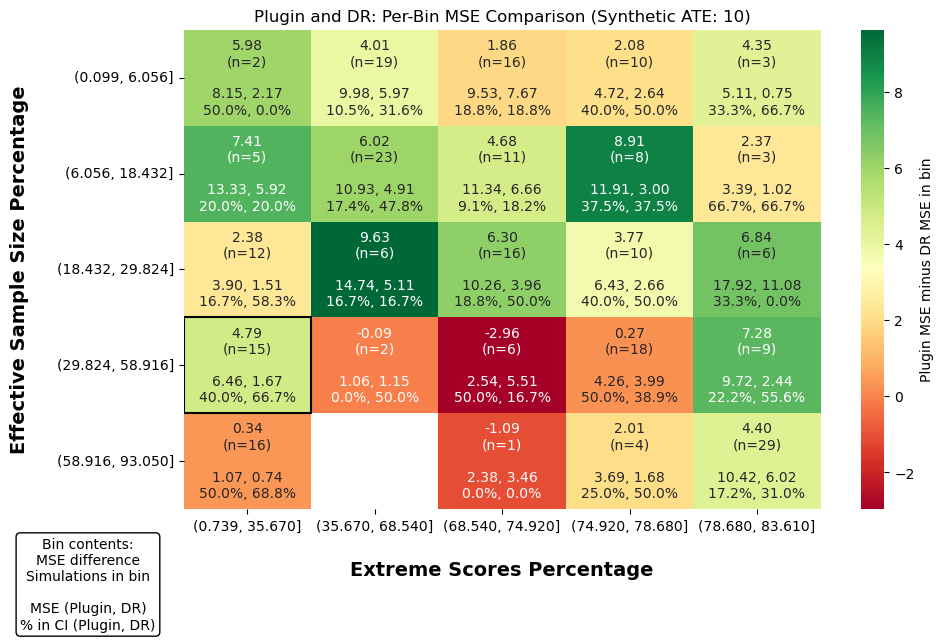

In [138]:
mean_matrix = np.zeros((len(ess_categories), len(extreme_scores_categories)))
str_matrix = np.empty((len(ess_categories), len(extreme_scores_categories)), dtype=object)

for i, ess_cat in enumerate(ess_categories):
    for j, extreme_scores_cat in enumerate(extreme_scores_categories):
        data_true_bin = ''
        if ess_cat == true_ess_bin and extreme_scores_cat == true_extreme_bin:
            true_bin_i, true_bin_j = i, j
        
        mask = (extreme_scores_bins == extreme_scores_cat) & (ess_bins == ess_cat)
        indices = np.where(mask)[0]
        
        if len(indices) > 0:
            dr_bias = dr_estimates[indices].mean() - synthetic_ate
            dr_var = dr_estimates[indices].var(ddof=0)
            dr_mse = dr_bias**2 + dr_var
            plugin_bias = plugin_estimates[indices].mean() - synthetic_ate
            plugin_var = plugin_estimates[indices].var(ddof=0)
            plugin_mse = plugin_bias**2 + plugin_var
            plugin_mse_minus_dr_mse = plugin_mse - dr_mse
            dr_perc_in_ci = dr_cis[indices].mean() * 100
            plugin_perc_in_ci = plugin_cis[indices].mean() * 100
            mean_matrix[i, j] = plugin_mse_minus_dr_mse
            str_matrix[i, j] = f"{plugin_mse_minus_dr_mse:.2f}\n(n={len(indices)})\n\n{plugin_mse:.2f}, {dr_mse:.2f}\n{plugin_perc_in_ci:.1f}%, {dr_perc_in_ci:.1f}%"
        else:
            mean_matrix[i, j] = np.nan
            str_matrix[i, j] = np.nan

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(mean_matrix, annot=str_matrix, annot_kws={'size': 10}, fmt='', cmap='RdYlGn', 
            xticklabels=[f"({interval.left:.3f}, {interval.right:.3f}]" for interval in extreme_scores_categories],
            yticklabels=[f"({interval.left:.3f}, {interval.right:.3f}]" for interval in ess_categories],
            cbar_kws={'label': 'Plugin MSE minus DR MSE in bin'},
            ax=ax)

if true_bin_i is not None and true_bin_j is not None:
    true_bin_edge = Rectangle((true_bin_j, true_bin_i), 1, 1, fill=False, edgecolor='black', linewidth=1.5)
    ax.add_patch(true_bin_edge)

ax.set_xlabel('\nExtreme Scores Percentage', fontweight='bold', fontsize=14)
ax.set_ylabel('Effective Sample Size Percentage\n', fontweight='bold', fontsize=14)
ax.set_title(f'Plugin and DR: Per-Bin MSE Comparison (Synthetic ATE: {synthetic_ate})')

legend_text = "Bin contents:\nMSE difference\nSimulations in bin\n\nMSE (Plugin, DR)\n% in CI (Plugin, DR)"
plt.figtext(-0.15, -0.25, legend_text, transform=ax.transAxes, fontsize=10,
        bbox=dict(boxstyle='round', facecolor='white'), horizontalalignment='center')

plt.tight_layout()
plt.show()

In [125]:
(root / "results").mkdir(parents=True, exist_ok=True)

In [126]:
results_df = pd.DataFrame(iterations_dict)
results_df.to_csv(root / f"results/iterations_results_{iterations}.csv", index=False)

In [127]:
fig.savefig(root / f"results/overlap_heatmap_{iterations}.png", dpi=500, bbox_inches='tight')

---

In [ ]:
binned_data = pd.DataFrame({
    'extreme_scores_bin': extreme_scores_bins,
    'ess_bin': ess_bins,
    'observation': observations
})

# Group by both bins
grouped = binned_data.groupby(['extreme_scores_bin', 'ess_bin'])['observation'].apply(list)
grouped

extreme_scores_bin  ess_bin         
(9.728, 24.196]     (52.192, 68.946]    [(0.1003829713827133, 9.8, 52.51, 10.013444774...
(38.592, 52.988]    (1.846, 18.684]     [(0.24749700491330315, 49.21, 2.88, 10.7914707...
(52.988, 67.384]    (1.846, 18.684]     [(0.365273532258038, 61.98, 1.93, 10.646231956...
(67.384, 81.78]     (18.684, 35.438]    [(0.49168259890625243, 71.68, 21.23, 10.129885...
                    (35.438, 52.192]    [(0.7759323263995945, 72.82, 36.75, 10.0163815...
                    (52.192, 68.946]    [(0.9731786341983883, 79.21, 60.79, 9.07688228...
                    (68.946, 85.7]      [(0.7588144813221372, 81.78, 85.7, 9.238584027...
Name: observation, dtype: object

In [465]:
binned_data

,extreme_scores_bin,ess_bin,observation
0,"(67.384, 81.78]","(18.684, 35.438]","(0.49168259890625243, 71.68, 21.23, 10.1298857..."
1,"(67.384, 81.78]","(68.946, 85.7]","(0.7588144813221372, 81.78, 85.7, 9.2385840272..."
2,"(38.592, 52.988]","(1.846, 18.684]","(0.24749700491330315, 49.21, 2.88, 10.79147072..."
3,"(67.384, 81.78]","(35.438, 52.192]","(0.7759323263995945, 72.82, 36.75, 10.01638150..."
4,"(67.384, 81.78]","(52.192, 68.946]","(0.9731786341983883, 79.21, 60.79, 9.076882287..."
5,"(67.384, 81.78]","(18.684, 35.438]","(0.6033530281123434, 74.41, 29.74, 7.883121400..."
6,"(52.988, 67.384]","(1.846, 18.684]","(0.365273532258038, 61.98, 1.93, 10.6462319564..."
7,"(9.728, 24.196]","(52.192, 68.946]","(0.1003829713827133, 9.8, 52.51, 10.0134447743..."
8,"(67.384, 81.78]","(18.684, 35.438]","(0.5772741646928671, 77.87, 24.79, 9.050017899..."
9,"(52.988, 67.384]","(1.846, 18.684]","(0.4144455765293731, 66.98, 10.85, 10.82111022..."


In [461]:
pd.cut(iterations_dict['extreme_scores'], bins=5)

[(67.384, 81.78], (67.384, 81.78], (38.592, 52.988], (67.384, 81.78], (67.384, 81.78], (67.384, 81.78], (52.988, 67.384], (9.728, 24.196], (67.384, 81.78], (52.988, 67.384]]
Categories (5, interval[float64, right]): [(9.728, 24.196] < (24.196, 38.592] < (38.592, 52.988] < (52.988, 67.384] < (67.384, 81.78]]

In [462]:
pd.cut(iterations_dict['ess'], bins=5)

[(18.684, 35.438], (68.946, 85.7], (1.846, 18.684], (35.438, 52.192], (52.192, 68.946], (18.684, 35.438], (1.846, 18.684], (52.192, 68.946], (18.684, 35.438], (1.846, 18.684]]
Categories (5, interval[float64, right]): [(1.846, 18.684] < (18.684, 35.438] < (35.438, 52.192] < (52.192, 68.946] < (68.946, 85.7]]

In [452]:
list(zip(*iterations_dict.values()))

---

In [ ]:
df_scaled_synthetic = df_scaled[covariate_cols]
df_scaled_synthetic['synthetic_y'], df_scaled_synthetic['synthetic_treat'] = synthetic_data(df_scaled[covariate_cols], 0.01)

In [404]:
df_scaled_synthetic['prop_scores'] = propensity_scores(df_scaled_synthetic, covariate_cols, 'synthetic_treat')

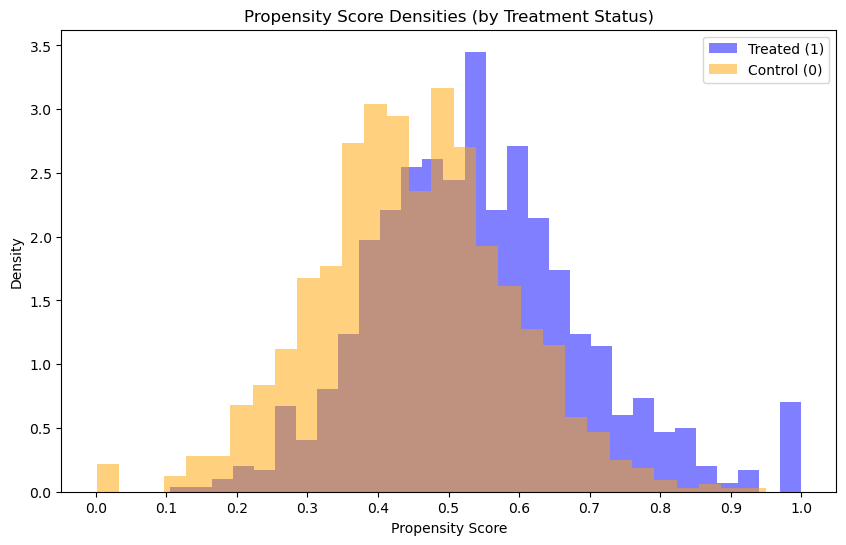

In [405]:
plot_propensity_scores(df_scaled_synthetic, 'synthetic_treat', 'prop_scores')

In [406]:
overlap_measures(df_scaled_synthetic, 'synthetic_treat', 'prop_scores')

In [407]:
df_scaled_synthetic.head()

,"AAGE_bin_(1.99, 4.0]","AAGE_bin_(10.0, 12.0]","AAGE_bin_(4.0, 6.0]","AAGE_bin_(6.0, 8.0]","AAGE_bin_(8.0, 10.0]",AGE,"ANXIOUS_bin_(-0.01, 2.0]","ANXIOUS_bin_(2.0, 4.0]","ANXIOUS_bin_(4.0, 6.0]","ANXIOUS_bin_(6.0, 8.0]",...,"WRKING_bin_(1.5, 2.0]","edageband_bin_(10.916, 27.8]","edageband_bin_(27.8, 44.6]","edageband_bin_(44.6, 61.4]","edageband_bin_(61.4, 78.2]","edageband_bin_(78.2, 95.0]",synthetic_y,synthetic_treat,prop_scores,ipw
20,-0.266552,-0.418452,-0.529246,1.566203,-0.617794,0.197454,-0.884804,-0.487591,2.034686,-0.399483,...,-0.322219,0.165732,-0.104933,-0.022255,0.0,-0.124843,57.396571,1,0.405512,2.466015
137,-0.266552,-0.418452,-0.529246,1.566203,-0.617794,-0.247202,1.130194,-0.487591,-0.491476,-0.399483,...,-0.322219,0.165732,-0.104933,-0.022255,0.0,-0.124843,25.290775,1,0.384497,2.600799
156,-0.266552,-0.418452,-0.529246,-0.638487,1.618664,0.997835,1.130194,-0.487591,-0.491476,-0.399483,...,-0.322219,0.165732,-0.104933,-0.022255,0.0,-0.124843,2.117489,0,0.443872,1.798148
231,-0.266552,-0.418452,1.889480,-0.638487,-0.617794,-1.136514,-0.884804,-0.487591,2.034686,-0.399483,...,-0.322219,0.165732,-0.104933,-0.022255,0.0,-0.124843,13.850052,0,0.371382,1.590792
269,-0.266552,-0.418452,1.889480,-0.638487,-0.617794,-1.225446,1.130194,-0.487591,-0.491476,-0.399483,...,-0.322219,0.165732,-0.104933,-0.022255,0.0,-0.124843,-0.873370,0,0.439405,1.783819


---

In [409]:
def dml_ate(df, covariate_cols, treatment_col, outcome_col):
    dml_model = DML(
        model_y=LassoCV(),
        model_t=LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
        discrete_treatment=True,
        model_final=StatsModelsLinearRegression(fit_intercept=False),
    )

    dml_model.fit(df[outcome_col], df[treatment_col], X=df[covariate_cols])
    dml_estimate = dml_model.ate(T0=0, T1=1, X=df[covariate_cols])

    return dml_estimate

In [410]:
riesz_estimate = riesz_ate(df_scaled_synthetic, covariate_cols, 'synthetic_treat', 'synthetic_y')
print(riesz_estimate.summary_text())

n=2020, cross_fit=True, folds=5, alpha=0.05, null=0.0
 AIPW (shared):  1.455693  (se=0.666392)  CI[95%]=0.149589,2.761798  p=0.02893
   DM (shared):  1.907547  (se=0.004057)  CI[95%]=1.899595,1.915500  p=0
           IPW:  1.070506  (se=1.233538)  CI[95%]=-1.347183,3.488195  p=0.3855


In [411]:
#dml_ate(df_scaled_synthetic, covariate_cols, 'synthetic_treat', 'synthetic_y')

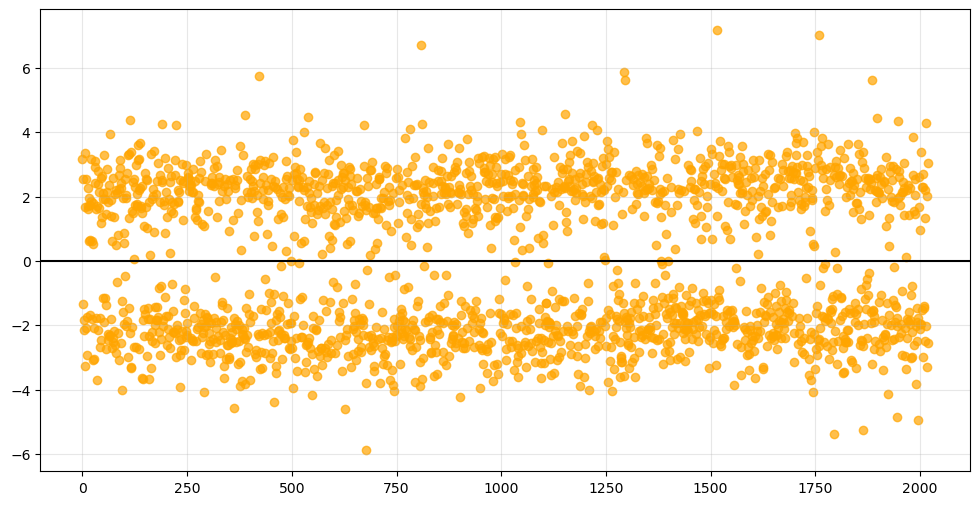

In [419]:
plt.figure(figsize=(12, 6))
plt.scatter(x=range(len(riesz_estimate.alpha_hat)), y=riesz_estimate.alpha_hat, label='alpha_hat', alpha=0.7, color='orange')
plt.axhline(y=0, color='black')
plt.grid(alpha=0.3)
